In [9]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
from scipy import fftpack
%matplotlib inline

In [2]:
# region = 'wpacific'
# lon_box = [95, 200]
# lat_box = [-25, 15]

region = 'tropics'
lon_box = [0, 359.9]
lat_box = [-25, 15]

test = ''
# test = '_ccs1_2h'
# rootdir = '/global/cscratch1/sd/feng045/E3SM/SCREAMv0/'
# obsfile = f'{rootdir}gpm_1200x3600/stats{test}/robust_mcs_tracks_20200120_20200228.nc'
# e3smfile = f'{rootdir}mcs_1200x3600/stats{test}/robust_mcs_tracks_20200120_20200228.nc'
rootdir = '/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/'
obsfile = f'{rootdir}gpm_1200x3600/stats{test}/mcs_tracks_final_20200120.0000_20200301.0000.nc'
e3smfile = f'{rootdir}mcs_1200x3600/stats{test}/mcs_tracks_final_20200120.0000_20200301.0000.nc'

pixel_radius_obs = 10
pixel_radius_e3sm = 10

figdir = f'/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/mcs_1200x3600/figures{test}/'
# figdir = f'/Users/feng045/results/E3SM/SCREAMv0/mcs_1200x3600/figures{test}/'
os.makedirs(figdir, exist_ok=True)

In [3]:
def find_track_in_region(times, lons, lats, lon_bounds, lat_bounds):
    
    # Get the track initiation month and location
#     start_month = times.isel(times=0).dt.month
    start_lon = lons.isel(times=0)
    start_lat = lats.isel(times=0)

    # Find tracks that initiates within a region
    mcsidx = np.where((start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
                      (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)))[0]
    print('Number of MCS: ', len(mcsidx))
    return mcsidx

In [4]:
# Read OBS data
dsobs = xr.open_dataset(obsfile)
# dsobs

In [5]:
# Read E3SM data
dsm1 = xr.open_dataset(e3smfile)
# dsm1

In [6]:
# # Get track initial time valuees
# base_time_obs = dsobs.base_time.load()
# starttime_obs = base_time_obs.isel(times=0)
# landfrac_obs = dsobs.pf_landfrac.load()
# lat0_obs = dsobs.meanlat.isel(times=0)
# lon0_obs = dsobs.meanlon.isel(times=0)
# landfrac0_obs = landfrac_obs.isel(times=0)
# print(f'Number of MCS (OBS): {len(lat0_obs)}')

In [7]:
# # Get track initial time valuees
# base_time_e3sm = dsm1.base_time.load()
# starttime_e3sm = base_time_e3sm.isel(times=0)
# landfrac_e3sm = dsm1.pf_landfrac.load()
# lat0_e3sm = dsm1.meanlat.isel(times=0)
# lon0_e3sm = dsm1.meanlon.isel(times=0)
# landfrac0_e3sm = landfrac_e3sm.isel(times=0)
# print(f'Number of MCS (E3SM): {len(lat0_e3sm)}')

In [8]:
mcsidx_obs = find_track_in_region(dsobs.base_time, dsobs.meanlon, dsobs.meanlat, lon_box, lat_box)
mcsidx_m1 = find_track_in_region(dsm1.base_time, dsm1.meanlon, dsm1.meanlat, lon_box, lat_box)

Number of MCS:  2380
Number of MCS:  2008


In [15]:
dsobs.merge_ccs_area.sum(dim='mergers')

<xarray.DataArray 'merge_ccs_area' (tracks: 3068, times: 200)>
array([[ 22200.,  20700.,   6400., ...,      0.,      0.,      0.],
       [223500., 254700., 154900., ...,      0.,      0.,      0.],
       [  3000.,   8900.,   1100., ...,      0.,      0.,      0.],
       ...,
       [ 37100.,      0.,      0., ...,      0.,      0.,      0.],
       [ 62800.,  76600.,  31400., ...,      0.,      0.,      0.],
       [ 41200.,   1200.,      0., ...,      0.,      0.,      0.]],
      dtype=float32)
Coordinates:
  * tracks   (tracks) int64 0 1 2 3 4 5 6 ... 3061 3062 3063 3064 3065 3066 3067
  * times    (times) int64 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199

In [14]:
dsobs.ccs_area

<xarray.DataArray 'ccs_area' (tracks: 3068, times: 200)>
[613600 values with dtype=float32]
Coordinates:
  * tracks   (tracks) int64 0 1 2 3 4 5 6 ... 3061 3062 3063 3064 3065 3066 3067
  * times    (times) int64 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199
Attributes:
    long_name:  Area of cold cloud shield
    units:      km^2

In [16]:
stime_obs = dsobs.base_time.isel(times=0, tracks=mcsidx_obs)
syear_obs = stime_obs.dt.year
smonth_obs = stime_obs.dt.month
shour_obs = stime_obs.dt.hour

time_res_obs = dsobs.attrs['time_resolution_hour']
ccslifetime_obs = dsobs.track_duration.isel(tracks=mcsidx_obs) * time_res_obs
lifetime_obs = dsobs.pf_lifetime.isel(tracks=mcsidx_obs)
ccsarea_obs = dsobs.ccs_area.isel(tracks=mcsidx_obs)
# Sum over mergers dimension to get total merge/split CCS area
ccsarea_merge_obs = dsobs.merge_ccs_area.isel(tracks=mcsidx_obs).sum(dim='mergers')
ccsarea_split_obs = dsobs.split_ccs_area.isel(tracks=mcsidx_obs).sum(dim='mergers')
# Add mergers/splits to CCS area as total CCS area
# This is consistent with how volume rainfall is calculated
ccsarea_obs = ccsarea_obs + ccsarea_merge_obs + ccsarea_split_obs
ccsdiam_obs = 2 * np.sqrt(ccsarea_obs / np.pi)
mintb_obs = dsobs.corecold_mintb.isel(tracks=mcsidx_obs)
mcsstatus_obs = dsobs.mcs_status.isel(tracks=mcsidx_obs)
pflon_obs = dsobs.pf_lon.isel(tracks=mcsidx_obs, nmaxpf=0)
pflat_obs = dsobs.pf_lat.isel(tracks=mcsidx_obs, nmaxpf=0)
pfarea_obs = dsobs.pf_area.isel(tracks=mcsidx_obs, nmaxpf=0)
pfdiam_obs = 2 * np.sqrt(pfarea_obs / np.pi)
maxpfdiam_obs = pfdiam_obs.max(dim='times')
startstatus_obs = dsobs.start_status.isel(tracks=mcsidx_obs)
endstatus_obs = dsobs.end_status.isel(tracks=mcsidx_obs)

pfrainrate_obs = dsobs.pf_rainrate.isel(tracks=mcsidx_obs, nmaxpf=0)
pfaccumrain_obs = dsobs.pf_accumrain.isel(tracks=mcsidx_obs).sum(dim='nmaxpf')
maxpfrainrate_obs = pfrainrate_obs.max(dim='times')
meanpfrainrate_obs = pfrainrate_obs.mean(dim='times')

# Compute volume rainrate [unit: kg/h]
pfvolrain_obs = (dsobs.pf_accumrain.sum(dim='nmaxpf') * pixel_radius_obs**2).isel(tracks=mcsidx_obs)
pfvolrainheavy_obs = (dsobs.pf_accumrainheavy.sum(dim='nmaxpf') * pixel_radius_obs**2).isel(tracks=mcsidx_obs)

landfrac_obs = dsobs.pf_landfrac.isel(tracks=mcsidx_obs)
init_landfrac_obs = landfrac_obs.isel(times=0)

# Use initiation location to define land vs. oean
mcsidx_land_obs = np.where(init_landfrac_obs > 0.8)[0]
mcsidx_ocean_obs = np.where(init_landfrac_obs < 0.2)[0]
# mcsidx_land_obs = np.where(init_landfrac_obs < 0.1)[0]
# mcsidx_ocean_obs = np.where(init_landfrac_obs > 0.8)[0]
nmcs_land_obs = len(mcsidx_land_obs)
nmcs_ocean_obs = len(mcsidx_ocean_obs)

print(f'Number of land MCS (OBS): {nmcs_land_obs}, Number of ocean MCS (OBS): {nmcs_ocean_obs}')

Number of land MCS (OBS): 768, Number of ocean MCS (OBS): 1261


In [17]:
stime_m1 = dsm1.base_time.isel(times=0, tracks=mcsidx_m1)
syear_m1 = stime_m1.dt.year
smonth_m1 = stime_m1.dt.month
shour_m1 = stime_m1.dt.hour

time_res_m1 = dsm1.attrs['time_resolution_hour']
ccslifetime_m1 = dsm1.track_duration.isel(tracks=mcsidx_m1) * time_res_m1
lifetime_m1 = dsm1.pf_lifetime.isel(tracks=mcsidx_m1)
ccsarea_m1 = dsm1.ccs_area.isel(tracks=mcsidx_m1)
# Sum over mergers dimension to get total merge/split CCS area
ccsarea_merge_m1 = dsm1.merge_ccs_area.isel(tracks=mcsidx_m1).sum(dim='mergers')
ccsarea_split_m1 = dsm1.split_ccs_area.isel(tracks=mcsidx_m1).sum(dim='mergers')
# Add mergers/splits to CCS area as total CCS area
# This is consistent with how volume rainfall is calculated
ccsarea_m1 = ccsarea_m1 + ccsarea_merge_m1 + ccsarea_split_m1
ccsdiam_m1 = 2 * np.sqrt(ccsarea_m1 / np.pi)
mintb_m1 = dsm1.corecold_mintb.isel(tracks=mcsidx_m1)
mcsstatus_m1 = dsm1.mcs_status.isel(tracks=mcsidx_m1)
pflon_m1 = dsm1.pf_lon.isel(tracks=mcsidx_m1, nmaxpf=0)
pflat_m1 = dsm1.pf_lat.isel(tracks=mcsidx_m1, nmaxpf=0)
pfarea_m1 = dsm1.pf_area.isel(tracks=mcsidx_m1, nmaxpf=0)
pfdiam_m1 = 2 * np.sqrt(pfarea_m1 / np.pi)
maxpfdiam_m1 = pfdiam_m1.max(dim='times')
startstatus_m1 = dsm1.start_status.isel(tracks=mcsidx_m1)
endstatus_m1 = dsm1.end_status.isel(tracks=mcsidx_m1)

pfrainrate_m1 = dsm1.pf_rainrate.isel(tracks=mcsidx_m1, nmaxpf=0)
pfaccumrain_m1 = dsm1.pf_accumrain.isel(tracks=mcsidx_m1).sum(dim='nmaxpf')
maxpfrainrate_m1 = pfrainrate_m1.max(dim='times')
meanpfrainrate_m1 = pfrainrate_m1.mean(dim='times')

# Compute volume rainrate [unit: kg/h]
pfvolrain_m1 = (dsm1.pf_accumrain.sum(dim='nmaxpf') * pixel_radius_e3sm**2).isel(tracks=mcsidx_m1)
pfvolrainheavy_m1 = (dsm1.pf_accumrainheavy.sum(dim='nmaxpf') * pixel_radius_e3sm**2).isel(tracks=mcsidx_m1)

landfrac_m1 = dsm1.pf_landfrac.isel(tracks=mcsidx_m1)
init_landfrac_m1 = landfrac_m1.isel(times=0)

# Use initiation location to define land vs. oean
mcsidx_land_m1 = np.where(init_landfrac_m1 > 0.8)[0]
mcsidx_ocean_m1 = np.where(init_landfrac_m1 < 0.2)[0]
nmcs_land_m1 = len(mcsidx_land_m1)
nmcs_ocean_m1 = len(mcsidx_ocean_m1)

print(f'Number of land MCS (E3SM): {nmcs_land_m1}, Number of ocean MCS (E3SM): {nmcs_ocean_m1}')

Number of land MCS (E3SM): 862, Number of ocean MCS (E3SM): 996


In [18]:
bt_land_obs = dsobs.base_time.isel(tracks=mcsidx_land_obs)
stime_land_obs = stime_obs.isel(tracks=mcsidx_land_obs)
syear_land_obs = stime_land_obs.dt.year
smonth_land_obs = stime_land_obs.dt.month
shour_land_obs = stime_land_obs.dt.hour

pflandfrac_land_obs = landfrac_obs.isel(tracks=mcsidx_land_obs)
ccsarea_land_obs = ccsarea_obs.isel(tracks=mcsidx_land_obs)
ccsdiam_land_obs = ccsdiam_obs.isel(tracks=mcsidx_land_obs)
mintb_land_obs = mintb_obs.isel(tracks=mcsidx_land_obs)
mcsstatus_land_obs = mcsstatus_obs.isel(tracks=mcsidx_land_obs)
pflon_land_obs = pflon_obs.isel(tracks=mcsidx_land_obs)
pflat_land_obs = pflat_obs.isel(tracks=mcsidx_land_obs)
ccslifetime_land_obs = ccslifetime_obs.isel(tracks=mcsidx_land_obs)
lifetime_land_obs = lifetime_obs.isel(tracks=mcsidx_land_obs)
pfarea_land_obs = pfarea_obs.isel(tracks=mcsidx_land_obs)
pfdiam_land_obs = pfdiam_obs.isel(tracks=mcsidx_land_obs)
pfrainrate_land_obs = pfrainrate_obs.isel(tracks=mcsidx_land_obs)
pfaccumrain_land_obs = pfaccumrain_obs.isel(tracks=mcsidx_land_obs)
maxpfdiam_land_obs = maxpfdiam_obs.isel(tracks=mcsidx_land_obs)
maxpfrainrate_land_obs = maxpfrainrate_obs.isel(tracks=mcsidx_land_obs)
meanpfrainrate_land_obs = meanpfrainrate_obs.isel(tracks=mcsidx_land_obs)
startstatus_land_obs = startstatus_obs.isel(tracks=mcsidx_land_obs)
endstatus_land_obs = endstatus_obs.isel(tracks=mcsidx_land_obs)
pfvolrain_land_obs = pfvolrain_obs.isel(tracks=mcsidx_land_obs)
pfvolrainheavy_land_obs = pfvolrainheavy_obs.isel(tracks=mcsidx_land_obs)

bt_ocean_obs = dsobs.base_time.isel(tracks=mcsidx_ocean_obs)
stime_ocean_obs = stime_obs.isel(tracks=mcsidx_ocean_obs)
syear_ocean_obs = stime_ocean_obs.dt.year
smonth_ocean_obs = stime_ocean_obs.dt.month
shour_ocean_obs = stime_ocean_obs.dt.hour

pflandfrac_ocean_obs = landfrac_obs.isel(tracks=mcsidx_ocean_obs)
ccsarea_ocean_obs = ccsarea_obs.isel(tracks=mcsidx_ocean_obs)
ccsdiam_ocean_obs = ccsdiam_obs.isel(tracks=mcsidx_ocean_obs)
mintb_ocean_obs = mintb_obs.isel(tracks=mcsidx_ocean_obs)
mcsstatus_ocean_obs = mcsstatus_obs.isel(tracks=mcsidx_ocean_obs)
pflon_ocean_obs = pflon_obs.isel(tracks=mcsidx_ocean_obs)
pflat_ocean_obs = pflat_obs.isel(tracks=mcsidx_ocean_obs)
ccslifetime_ocean_obs = ccslifetime_obs.isel(tracks=mcsidx_ocean_obs)
lifetime_ocean_obs = lifetime_obs.isel(tracks=mcsidx_ocean_obs)
pfarea_ocean_obs = pfarea_obs.isel(tracks=mcsidx_ocean_obs)
pfdiam_ocean_obs = pfdiam_obs.isel(tracks=mcsidx_ocean_obs)
pfrainrate_ocean_obs = pfrainrate_obs.isel(tracks=mcsidx_ocean_obs)
pfaccumrain_ocean_obs = pfaccumrain_obs.isel(tracks=mcsidx_ocean_obs)
maxpfdiam_ocean_obs = maxpfdiam_obs.isel(tracks=mcsidx_ocean_obs)
maxpfrainrate_ocean_obs = maxpfrainrate_obs.isel(tracks=mcsidx_ocean_obs)
meanpfrainrate_ocean_obs = meanpfrainrate_obs.isel(tracks=mcsidx_ocean_obs)
startstatus_ocean_obs = startstatus_obs.isel(tracks=mcsidx_ocean_obs)
endstatus_ocean_obs = endstatus_obs.isel(tracks=mcsidx_ocean_obs)
pfvolrain_ocean_obs = pfvolrain_obs.isel(tracks=mcsidx_ocean_obs)
pfvolrainheavy_ocean_obs = pfvolrainheavy_obs.isel(tracks=mcsidx_ocean_obs)

In [19]:
bt_land_m1 = dsm1.base_time.isel(tracks=mcsidx_land_m1)
stime_land_m1 = stime_m1.isel(tracks=mcsidx_land_m1)
syear_land_m1 = stime_land_m1.dt.year
smonth_land_m1 = stime_land_m1.dt.month
shour_land_m1 = stime_land_m1.dt.hour

pflandfrac_land_m1 = landfrac_m1.isel(tracks=mcsidx_land_m1)
ccsarea_land_m1 = ccsarea_m1.isel(tracks=mcsidx_land_m1)
ccsdiam_land_m1 = ccsdiam_m1.isel(tracks=mcsidx_land_m1)
mintb_land_m1 = mintb_m1.isel(tracks=mcsidx_land_m1)
mcsstatus_land_m1 = mcsstatus_m1.isel(tracks=mcsidx_land_m1)
pflon_land_m1 = pflon_m1.isel(tracks=mcsidx_land_m1)
pflat_land_m1 = pflat_m1.isel(tracks=mcsidx_land_m1)
ccslifetime_land_m1 = ccslifetime_m1.isel(tracks=mcsidx_land_m1)
lifetime_land_m1 = lifetime_m1.isel(tracks=mcsidx_land_m1)
pfarea_land_m1 = pfarea_m1.isel(tracks=mcsidx_land_m1)
pfdiam_land_m1 = pfdiam_m1.isel(tracks=mcsidx_land_m1)
pfrainrate_land_m1 = pfrainrate_m1.isel(tracks=mcsidx_land_m1)
pfaccumrain_land_m1 = pfaccumrain_m1.isel(tracks=mcsidx_land_m1)
maxpfdiam_land_m1 = maxpfdiam_m1.isel(tracks=mcsidx_land_m1)
maxpfrainrate_land_m1 = maxpfrainrate_m1.isel(tracks=mcsidx_land_m1)
meanpfrainrate_land_m1 = meanpfrainrate_m1.isel(tracks=mcsidx_land_m1)
startstatus_land_m1 = startstatus_m1.isel(tracks=mcsidx_land_m1)
endstatus_land_m1 = endstatus_m1.isel(tracks=mcsidx_land_m1)
pfvolrain_land_m1 = pfvolrain_m1.isel(tracks=mcsidx_land_m1)
pfvolrainheavy_land_m1 = pfvolrainheavy_m1.isel(tracks=mcsidx_land_m1)

bt_ocean_m1 = dsm1.base_time.isel(tracks=mcsidx_ocean_m1)
stime_ocean_m1 = stime_m1.isel(tracks=mcsidx_ocean_m1)
syear_ocean_m1 = stime_ocean_m1.dt.year
smonth_ocean_m1 = stime_ocean_m1.dt.month
shour_ocean_m1 = stime_ocean_m1.dt.hour

pflandfrac_ocean_m1 = landfrac_m1.isel(tracks=mcsidx_ocean_m1)
ccsarea_ocean_m1 = ccsarea_m1.isel(tracks=mcsidx_ocean_m1)
ccsdiam_ocean_m1 = ccsdiam_m1.isel(tracks=mcsidx_ocean_m1)
mintb_ocean_m1 = mintb_m1.isel(tracks=mcsidx_ocean_m1)
mcsstatus_ocean_m1 = mcsstatus_m1.isel(tracks=mcsidx_ocean_m1)
pflon_ocean_m1 = pflon_m1.isel(tracks=mcsidx_ocean_m1)
pflat_ocean_m1 = pflat_m1.isel(tracks=mcsidx_ocean_m1)
ccslifetime_ocean_m1 = ccslifetime_m1.isel(tracks=mcsidx_ocean_m1)
lifetime_ocean_m1 = lifetime_m1.isel(tracks=mcsidx_ocean_m1)
pfarea_ocean_m1 = pfarea_m1.isel(tracks=mcsidx_ocean_m1)
pfdiam_ocean_m1 = pfdiam_m1.isel(tracks=mcsidx_ocean_m1)
pfrainrate_ocean_m1 = pfrainrate_m1.isel(tracks=mcsidx_ocean_m1)
pfaccumrain_ocean_m1 = pfaccumrain_m1.isel(tracks=mcsidx_ocean_m1)
maxpfdiam_ocean_m1 = maxpfdiam_m1.isel(tracks=mcsidx_ocean_m1)
maxpfrainrate_ocean_m1 = maxpfrainrate_m1.isel(tracks=mcsidx_ocean_m1)
meanpfrainrate_ocean_m1 = meanpfrainrate_m1.isel(tracks=mcsidx_ocean_m1)
startstatus_ocean_m1 = startstatus_m1.isel(tracks=mcsidx_ocean_m1)
endstatus_ocean_m1 = endstatus_m1.isel(tracks=mcsidx_ocean_m1)
pfvolrain_ocean_m1 = pfvolrain_m1.isel(tracks=mcsidx_ocean_m1)
pfvolrainheavy_ocean_m1 = pfvolrainheavy_m1.isel(tracks=mcsidx_ocean_m1)

In [20]:
# life_bins = np.arange(4, 60.1, 4)
life_bins = np.arange(0, 60.1, 4)
binrange = (0, 60)
pdf_lifetime_land_obs, bins = np.histogram(lifetime_land_obs, bins=life_bins, range=binrange, density=True)
pdf_lifetime_ocean_obs, bins = np.histogram(lifetime_ocean_obs, bins=life_bins, range=binrange, density=True)

pdf_lifetime_land_m1, bins = np.histogram(lifetime_land_m1, bins=life_bins, range=binrange, density=True)
pdf_lifetime_ocean_m1, bins = np.histogram(lifetime_ocean_m1, bins=life_bins, range=binrange, density=True)

(array([9.47752013e-04, 2.91108627e-03, 1.02072798e-03, 3.21374942e-04,
        5.66031557e-05, 5.61353611e-06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([ 100.,  290.,  480.,  670.,  860., 1050., 1240., 1430., 1620.,
        1810., 2000.], dtype=float32),
 <BarContainer object of 10 artists>)

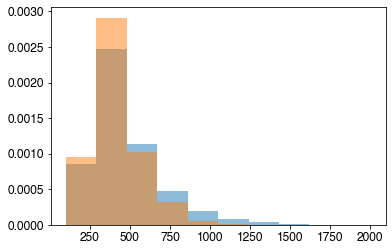

In [91]:
ccsdiam_ocean_obs.where(mcsstatus_ocean_obs == 1).plot.hist(range=(100,2000), alpha=0.5, density=True)
ccsdiam_ocean_m1.where(mcsstatus_ocean_m1 == 1).plot.hist(range=(100,2000), alpha=0.5, density=True)

(array([   0.,    0.,    0.,  269.,  925., 3353., 9384., 3576.,   76.,
           0.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

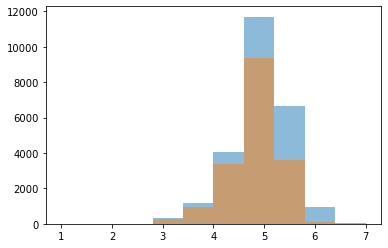

In [22]:
np.log10(ccsarea_ocean_obs).plot.hist(range=(1,7), alpha=0.5)
np.log10(ccsarea_ocean_m1).plot.hist(range=(1,7), alpha=0.5)

In [23]:
ccsarea_bins = np.arange(2, 7.01, 0.2)
binrange = (2, 7)
pdf_ccsarea_land_obs, bins = np.histogram(np.log10(ccsarea_land_obs), bins=ccsarea_bins, range=binrange, density=True)
pdf_ccsarea_ocean_obs, bins = np.histogram(np.log10(ccsarea_ocean_obs), bins=ccsarea_bins, range=binrange, density=True)

pdf_ccsarea_land_m1, bins = np.histogram(np.log10(ccsarea_land_m1), bins=ccsarea_bins, range=binrange, density=True)
pdf_ccsarea_ocean_m1, bins = np.histogram(np.log10(ccsarea_ocean_m1), bins=ccsarea_bins, range=binrange, density=True)

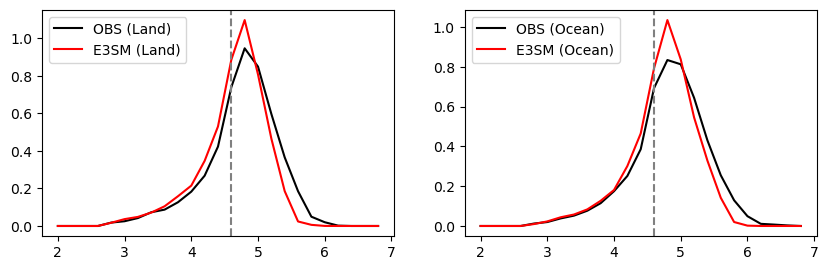

In [24]:
fig, axs = plt.subplots(1,2, figsize=[10,3], dpi=100)
ax = axs[0]
ax.plot(ccsarea_bins[:-1], pdf_ccsarea_land_obs, color='k', label='OBS (Land)')
ax.plot(ccsarea_bins[:-1], pdf_ccsarea_land_m1, color='r', label='E3SM (Land)')
ax.axvline(np.log10(dsobs.attrs['MCS_area_km^2']), color='gray', ls='--')
ax.legend()

ax = axs[1]
ax.plot(ccsarea_bins[:-1], pdf_ccsarea_ocean_obs, color='k', label='OBS (Ocean)')
ax.plot(ccsarea_bins[:-1], pdf_ccsarea_ocean_m1, color='r', label='E3SM (Ocean)')
ax.axvline(np.log10(dsobs.attrs['MCS_area_km^2']), color='gray', ls='--')
ax.legend()

In [112]:
ccsdiam_bins = np.arange(0, 1500.1, 50)
binrange = (0, 1500)
pdf_ccsdiam_land_obs, bins = np.histogram(ccsdiam_land_obs, bins=ccsdiam_bins, range=binrange, density=True)
pdf_ccsdiam_ocean_obs, bins = np.histogram(ccsdiam_ocean_obs, bins=ccsdiam_bins, range=binrange, density=True)

pdf_ccsdiam_land_m1, bins = np.histogram(ccsdiam_land_m1, bins=ccsdiam_bins, range=binrange, density=True)
pdf_ccsdiam_ocean_m1, bins = np.histogram(ccsdiam_ocean_m1, bins=ccsdiam_bins, range=binrange, density=True)

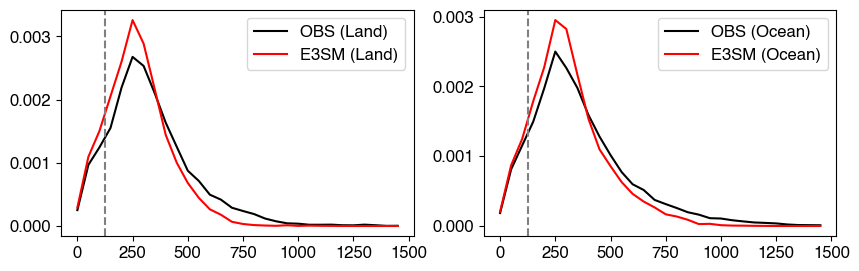

In [113]:
fig, axs = plt.subplots(1,2, figsize=[10,3], dpi=100)
ax = axs[0]
ax.plot(ccsdiam_bins[:-1], pdf_ccsdiam_land_obs, color='k', label='OBS (Land)')
ax.plot(ccsdiam_bins[:-1], pdf_ccsdiam_land_m1, color='r', label='E3SM (Land)')
ax.axvline(2*np.sqrt(dsobs.attrs['MCS_area_km^2'])/np.pi, color='gray', ls='--')
ax.legend()

ax = axs[1]
ax.plot(ccsdiam_bins[:-1], pdf_ccsdiam_ocean_obs, color='k', label='OBS (Ocean)')
ax.plot(ccsdiam_bins[:-1], pdf_ccsdiam_ocean_m1, color='r', label='E3SM (Ocean)')
ax.axvline(2*np.sqrt(dsobs.attrs['MCS_area_km^2'])/np.pi, color='gray', ls='--')
ax.legend()

In [25]:
# Parameters are selected during MCS stage (mcsstatus==1)
pfdiam_bins = np.arange(0,600.1,25)
binrange = (0,600)
pdf_pfdiam_land_obs, bins = np.histogram(pfdiam_land_obs.where(mcsstatus_land_obs == 1), bins=pfdiam_bins, range=binrange, density=True)
pdf_pfdiam_ocean_obs, bins = np.histogram(pfdiam_ocean_obs.where(mcsstatus_ocean_obs == 1), bins=pfdiam_bins, range=binrange, density=True)

pdf_pfdiam_land_m1, bins = np.histogram(pfdiam_land_m1.where(mcsstatus_land_m1 == 1), bins=pfdiam_bins, range=binrange, density=True)
pdf_pfdiam_ocean_m1, bins = np.histogram(pfdiam_ocean_m1.where(mcsstatus_ocean_m1 == 1), bins=pfdiam_bins, range=binrange, density=True)

In [26]:
# Parameters are selected during MCS stage (mcsstatus==1)
rainrate_bins = np.arange(0,20.01,0.5)
binrange = (0,20)
pdf_pfrainrate_land_obs, bins = np.histogram(pfrainrate_land_obs.where(mcsstatus_land_obs == 1), bins=rainrate_bins, range=binrange, density=True)
pdf_pfrainrate_ocean_obs, bins = np.histogram(pfrainrate_ocean_obs.where(mcsstatus_ocean_obs == 1), bins=rainrate_bins, range=binrange, density=True)

pdf_pfrainrate_land_m1, bins = np.histogram(pfrainrate_land_m1.where(mcsstatus_land_m1 == 1), bins=rainrate_bins, range=binrange, density=True)
pdf_pfrainrate_ocean_m1, bins = np.histogram(pfrainrate_ocean_m1.where(mcsstatus_ocean_m1 == 1), bins=rainrate_bins, range=binrange, density=True)

In [27]:
# volrain_bins = np.arange(0,3.01,0.25)
volrain_bins = np.logspace(np.log10(0.02), np.log10(4.0), 25)
binrange = (0,4)
volrain_scale = 1e6

pdf_volrain_land_obs, bins = np.histogram(pfvolrain_land_obs.where(mcsstatus_land_obs == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)
pdf_volrain_ocean_obs, bins = np.histogram(pfvolrain_ocean_obs.where(mcsstatus_ocean_obs == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)

pdf_volrain_land_m1, bins = np.histogram(pfvolrain_land_m1.where(mcsstatus_land_m1 == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)
pdf_volrain_ocean_m1, bins = np.histogram(pfvolrain_ocean_m1.where(mcsstatus_ocean_m1 == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)

In [28]:
# Heavy rain volume
pdf_volrainheavy_land_obs, bins = np.histogram(pfvolrainheavy_land_obs.where(mcsstatus_land_obs == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)
pdf_volrainheavy_ocean_obs, bins = np.histogram(pfvolrainheavy_ocean_obs.where(mcsstatus_ocean_obs == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)

pdf_volrainheavy_land_m1, bins = np.histogram(pfvolrainheavy_land_m1.where(mcsstatus_land_m1 == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)
pdf_volrainheavy_ocean_m1, bins = np.histogram(pfvolrainheavy_ocean_m1.where(mcsstatus_ocean_m1 == 1)/volrain_scale, bins=volrain_bins, range=binrange, density=True)

In [29]:
# Heavy rain volume ratio
pfhrr_land_obs = pfvolrainheavy_land_obs / pfvolrain_land_obs
pfhrr_ocean_obs = pfvolrainheavy_ocean_obs / pfvolrain_ocean_obs
pfhrr_land_m1 = pfvolrainheavy_land_m1 / pfvolrain_land_m1
pfhrr_ocean_m1 = pfvolrainheavy_ocean_m1 / pfvolrain_ocean_m1

hrr_bins = np.arange(0.05, 1.01, 0.05)
binrange = (0.05,1)
pdf_hrr_land_obs, bins = np.histogram(pfhrr_land_obs.where(mcsstatus_land_obs == 1), bins=hrr_bins, range=binrange, density=True)
pdf_hrr_ocean_obs, bins = np.histogram(pfhrr_ocean_obs.where(mcsstatus_ocean_obs == 1), bins=hrr_bins, range=binrange, density=True)

pdf_hrr_land_m1, bins = np.histogram(pfhrr_land_m1.where(mcsstatus_land_m1 == 1), bins=hrr_bins, range=binrange, density=True)
pdf_hrr_ocean_m1, bins = np.histogram(pfhrr_ocean_m1.where(mcsstatus_ocean_m1 == 1), bins=hrr_bins, range=binrange, density=True)

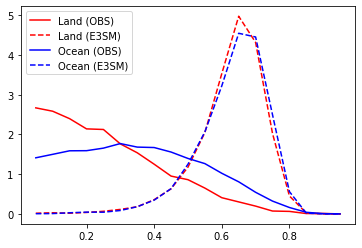

In [30]:
plt.plot(hrr_bins[:-1], pdf_hrr_land_obs, 'r', label='Land (OBS)')
plt.plot(hrr_bins[:-1], pdf_hrr_land_m1, 'r--', label=f'Land (E3SM)')
# plt.plot(hrr_bins[:-1], pdf_hrr_land_m2, 'r:', label=f'Land ({e3sm_name[runname2]})')

plt.plot(hrr_bins[:-1], pdf_hrr_ocean_obs, 'b', label='Ocean (OBS)')
plt.plot(hrr_bins[:-1], pdf_hrr_ocean_m1, 'b--', label=f'Ocean (E3SM)')
# plt.plot(hrr_bins[:-1], pdf_hrr_ocean_m2, 'b:', label=f'Ocean ({e3sm_name[runname2]})')
plt.legend()

In [31]:
def plot_pdf_8panels(bins, data_obs, data_m1, ns_obs, ns_m1,  
                     titles, xlabels, xticks, xscales, yscales, ylims, 
                     map_extent, lon_box, lat_box, inset_param, figname,
                     legend_fontsize=11, legend_loc='best'):
    mpl.rcParams['font.size'] = 11
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=[10,10], dpi=100)

    colors = {'obs':'steelblue', 'm1':'darkorange'}

    for row in range(0,4):
        for col in range(0,2): 
            ax = axes[row][col]
            ax.plot(bins[row][0:-1], data_obs[row][col], colors['obs'], lw=3, label=f'OBS ({ns_obs[row][col]})')
            ax.plot(bins[row][0:-1], data_m1[row][col], colors['m1'], lw=3, label=f'SCREAM ({ns_m1[row][col]})')
#             ax.plot(bins[row][0:-1], data_m2[row][col], colors['m2'], lw=3, label=f'{e3sm_name[runname2]} ({ns_m2[row][col]})')
#             ax.plot(bins[row][0:-1], data_m3[row][col], colors['m3'], lw=3, label=f'{e3sm_name[runname3]} ({ns_m3[row][col]})')
#             ax.plot(bins[row][0:-1], data_m4[row][col], colors['m4'], lw=3, label=f'{e3sm_name[runname4]} ({ns_m4[row][col]})')
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row])
            ax.set_ylabel('Frequency')
            ax.set_xticks(xticks[row])
            ax.set_ylim(ylims[row][0], ylims[row][1])
            ax.set_xscale(xscales[row])
            ax.set_yscale(yscales[row])
            if (row == 0):
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)

                # Plot inset map
                if (row==0): 
                    resolution = '110m'
                    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                    proj = ccrs.PlateCarree(central_longitude=180)
                    box_proj = ccrs.PlateCarree(central_longitude=0)
                    sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                        axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                        axes_kwargs=dict(map_projection=proj))
                    sub_ax.set_extent(map_extent, crs=box_proj)
                    # Add land, coastlines, borders to inset
                    sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                    sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                    sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=1)
                    # Plot a box region in the inset
                    box = sgeom.box(minx=lon_box[0], maxx=lon_box[1], miny=lat_box[0], maxy=lat_box[1])
                    sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                    sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.5, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [116]:
pdf_ccsdiam_land_obs

array([2.50566038e-04, 9.67547170e-04, 1.24377358e-03, 1.55018868e-03,
       2.18867925e-03, 2.67471698e-03, 2.53132075e-03, 2.10264151e-03,
       1.63471698e-03, 1.25283019e-03, 8.73962264e-04, 7.12452830e-04,
       4.95094340e-04, 4.16603774e-04, 2.88301887e-04, 2.36981132e-04,
       1.88679245e-04, 1.17735849e-04, 7.39622642e-05, 4.22641509e-05,
       3.62264151e-05, 1.96226415e-05, 1.96226415e-05, 2.11320755e-05,
       1.20754717e-05, 1.05660377e-05, 2.11320755e-05, 1.20754717e-05,
       1.50943396e-06, 3.01886792e-06])

/tmp/ipykernel_37718/1350660200.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


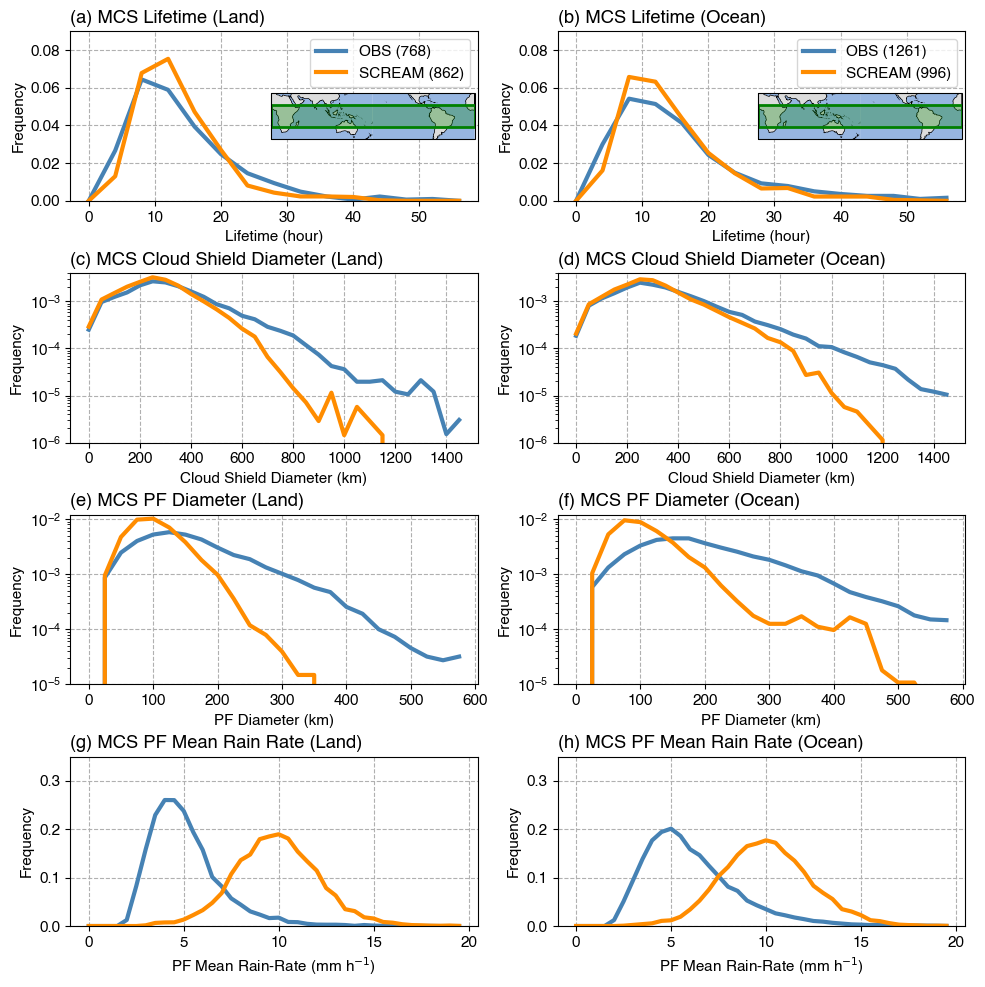

In [129]:
xbins = [life_bins, ccsdiam_bins, pfdiam_bins, rainrate_bins]
data_obs = [[pdf_lifetime_land_obs, pdf_lifetime_ocean_obs],
            # [pdf_ccsarea_land_obs, pdf_ccsarea_ocean_obs],
            [pdf_ccsdiam_land_obs, pdf_ccsdiam_ocean_obs],
            [pdf_pfdiam_land_obs, pdf_pfdiam_ocean_obs],
            [pdf_pfrainrate_land_obs, pdf_pfrainrate_ocean_obs]]
data_m1 = [[pdf_lifetime_land_m1, pdf_lifetime_ocean_m1],
           [pdf_ccsdiam_land_m1, pdf_ccsdiam_ocean_m1],
           [pdf_pfdiam_land_m1, pdf_pfdiam_ocean_m1],
           [pdf_pfrainrate_land_m1, pdf_pfrainrate_ocean_m1]]
ns_obs = [[nmcs_land_obs, nmcs_ocean_obs],
          [nmcs_land_obs, nmcs_ocean_obs],
          [nmcs_land_obs, nmcs_ocean_obs],
          [nmcs_land_obs, nmcs_ocean_obs]]
ns_m1 = [[nmcs_land_m1, nmcs_ocean_m1],
         [nmcs_land_m1, nmcs_ocean_m1],
          [nmcs_land_m1, nmcs_ocean_m1],
          [nmcs_land_m1, nmcs_ocean_m1]]
titles = [['(a) MCS Lifetime (Land)', '(b) MCS Lifetime (Ocean)'],
          ['(c) MCS Cloud Shield Diameter (Land)', '(d) MCS Cloud Shield Diameter (Ocean)'],
          ['(e) MCS PF Diameter (Land)', '(f) MCS PF Diameter (Ocean)'],
          ['(g) MCS PF Mean Rain Rate (Land)', '(h) MCS PF Mean Rain Rate (Ocean)']]
xlabels = ['Lifetime (hour)', 'Cloud Shield Diameter (km)', 'PF Diameter (km)', 'PF Mean Rain-Rate (mm h$^{-1}$)' ]
# xticks = [np.arange(5, 60.01, 10), np.arange(0,801,100), np.arange(0,15.1,3), np.arange(0,4.1,0.5)]
xticks = [np.arange(5, 60.01, 10), np.arange(0, 1200.01, 200), np.arange(0,601,100), np.arange(0,15.1,3),]
xscales = ['linear', 'linear', 'linear','linear']
yscales = ['linear', 'log', 'log','linear']
ylims = [[0,0.09],[1e-6,0.004],[1e-5,0.012],[0,0.35]]

# bounds = [lon_box[0], lon_box[1], lat_box[0], lat_box[1]]
# map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-15,bounds[3]+15]
# inset_param = {'width':'30%', 'height':'32%', 'loc':'center right', 'borderpad':0.2}
bounds = [lon_box[0], lon_box[1]-0.1, lat_box[0], lat_box[1]]
map_extent = [bounds[0],bounds[1],bounds[2]-20,bounds[3]+20]
inset_param = {'width':'50%', 'height':'30%', 'loc':'center right', 'borderpad':0.2}

fig = plot_pdf_8panels(xbins, data_obs, data_m1, ns_obs, ns_m1,
                       titles, xlabels, xticks, xscales, yscales, ylims, 
                       map_extent, lon_box, lat_box, inset_param, f'{figdir}pdf_lifetime_ccsdiam_pfdiam_rainrate_landocean_{region}.png')

/tmp/ipykernel_37718/1350660200.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


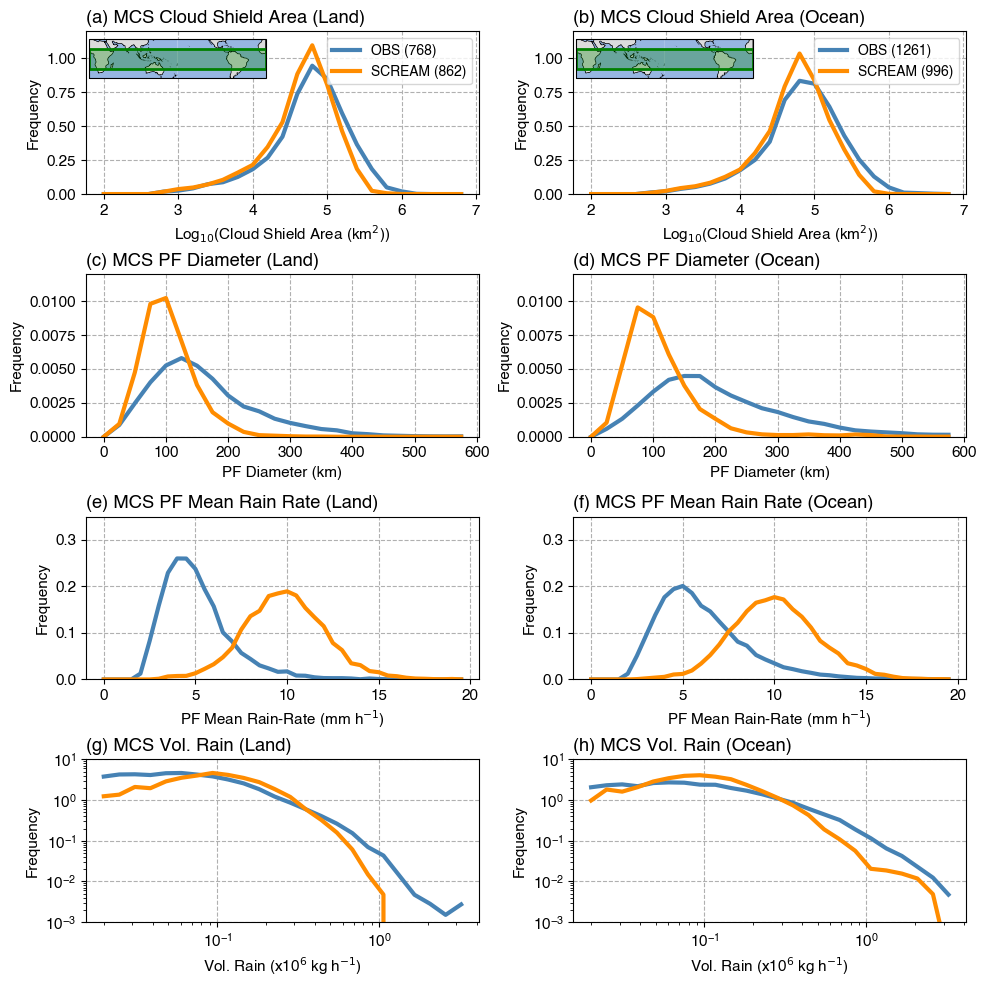

In [130]:
xbins = [ccsarea_bins, pfdiam_bins, rainrate_bins, volrain_bins]
data_obs = [[pdf_ccsarea_land_obs, pdf_ccsarea_ocean_obs],
            [pdf_pfdiam_land_obs, pdf_pfdiam_ocean_obs],
            [pdf_pfrainrate_land_obs, pdf_pfrainrate_ocean_obs], 
            [pdf_volrain_land_obs, pdf_volrain_ocean_obs]]
data_m1 = [[pdf_ccsarea_land_m1, pdf_ccsarea_ocean_m1],
           [pdf_pfdiam_land_m1, pdf_pfdiam_ocean_m1],
           [pdf_pfrainrate_land_m1, pdf_pfrainrate_ocean_m1],
           [pdf_volrain_land_m1, pdf_volrain_ocean_m1]]
ns_obs = [[nmcs_land_obs, nmcs_ocean_obs],
          [nmcs_land_obs, nmcs_ocean_obs],
          [nmcs_land_obs, nmcs_ocean_obs],
          [nmcs_land_obs, nmcs_ocean_obs]]
ns_m1 = [[nmcs_land_m1, nmcs_ocean_m1],
         [nmcs_land_m1, nmcs_ocean_m1],
          [nmcs_land_m1, nmcs_ocean_m1],
          [nmcs_land_m1, nmcs_ocean_m1]]
titles = [['(a) MCS Cloud Shield Area (Land)', '(b) MCS Cloud Shield Area (Ocean)'],
          ['(c) MCS PF Diameter (Land)', '(d) MCS PF Diameter (Ocean)'],
          ['(e) MCS PF Mean Rain Rate (Land)', '(f) MCS PF Mean Rain Rate (Ocean)'],
          ['(g) MCS Vol. Rain (Land)', '(h) MCS Vol. Rain (Ocean)']]
xlabels = ['Log$_{10}$(Cloud Shield Area (km$^2$))', 'PF Diameter (km)', 'PF Mean Rain-Rate (mm h$^{-1}$)', 'Vol. Rain (x10$^{6}$ kg h$^{-1}$)', ]
xticks = [np.arange(2, 7.01, 1), np.arange(0,601,100), np.arange(0,15.1,3), np.arange(0,4.1,0.5)]
xscales = ['linear', 'linear','linear','log']
yscales = ['linear', 'linear','linear','log']
ylims = [[0,1.2],[0,0.012],[0,0.35],[1e-3,10]]

# bounds = [lon_box[0], lon_box[1], lat_box[0], lat_box[1]]
# map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-15,bounds[3]+15]
# inset_param = {'width':'30%', 'height':'35%', 'loc':'upper left', 'borderpad':0.2}
bounds = [lon_box[0], lon_box[1]-0.1, lat_box[0], lat_box[1]]
map_extent = [bounds[0],bounds[1],bounds[2]-20,bounds[3]+20]
inset_param = {'width':'45%', 'height':'30%', 'loc':'upper left', 'borderpad':0.2}

fig = plot_pdf_8panels(xbins, data_obs, data_m1, ns_obs, ns_m1,
                       titles, xlabels, xticks, xscales, yscales, ylims, 
                       map_extent, lon_box, lat_box, inset_param, f'{figdir}pdf_ccsarea_pfdiam_rainrate_volrain_landocean_{region}.png', 
                       legend_loc='upper right', legend_fontsize=10)

In [35]:
def plot_pdf_6panels(bins, data_obs, data_m1, ns_obs, ns_m1,  
                     titles, xlabels, xticks, xscales, yscales, ylims, 
                     map_extent, lon_box, lat_box, inset_param, figname,
                     legend_fontsize=11, legend_loc='best'):
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=[10,8], dpi=100)

    colors = {'obs':'steelblue', 'm1':'darkorange'}

    for row in range(0,3):
        for col in range(0,2): 
            ax = axes[row][col]
            ax.plot(bins[row][0:-1], data_obs[row][col], colors['obs'], lw=3, label=f'OBS ({ns_obs[row][col]})')
            ax.plot(bins[row][0:-1], data_m1[row][col], colors['m1'], lw=3, label=f'SCREAM ({ns_m1[row][col]})')
#             ax.plot(bins[row][0:-1], data_m2[row][col], colors['m2'], lw=3, label=f'{e3sm_name[runname2]} ({ns_m2[row][col]})')
#             ax.plot(bins[row][0:-1], data_m3[row][col], colors['m3'], lw=3, label=f'{e3sm_name[runname3]} ({ns_m3[row][col]})')
#             ax.plot(bins[row][0:-1], data_m4[row][col], colors['m4'], lw=3, label=f'{e3sm_name[runname4]} ({ns_m4[row][col]})')
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row])
            ax.set_ylabel('Frequency')
            ax.set_xticks(xticks[row])
            ax.set_ylim(ylims[row][0], ylims[row][1])
            ax.set_xscale(xscales[row])
            ax.set_yscale(yscales[row])
            if (row == 0):
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            
            # Plot inset map
            if (row == 0):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                proj = ccrs.PlateCarree(central_longitude=180)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(map_projection=proj))
                sub_ax.set_extent(map_extent, crs=box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=1)
                # Plot a box region in the inset
                box = sgeom.box(minx=lon_box[0], maxx=lon_box[1], miny=lat_box[0], maxy=lat_box[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.5, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

/tmp/ipykernel_37718/4251700317.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


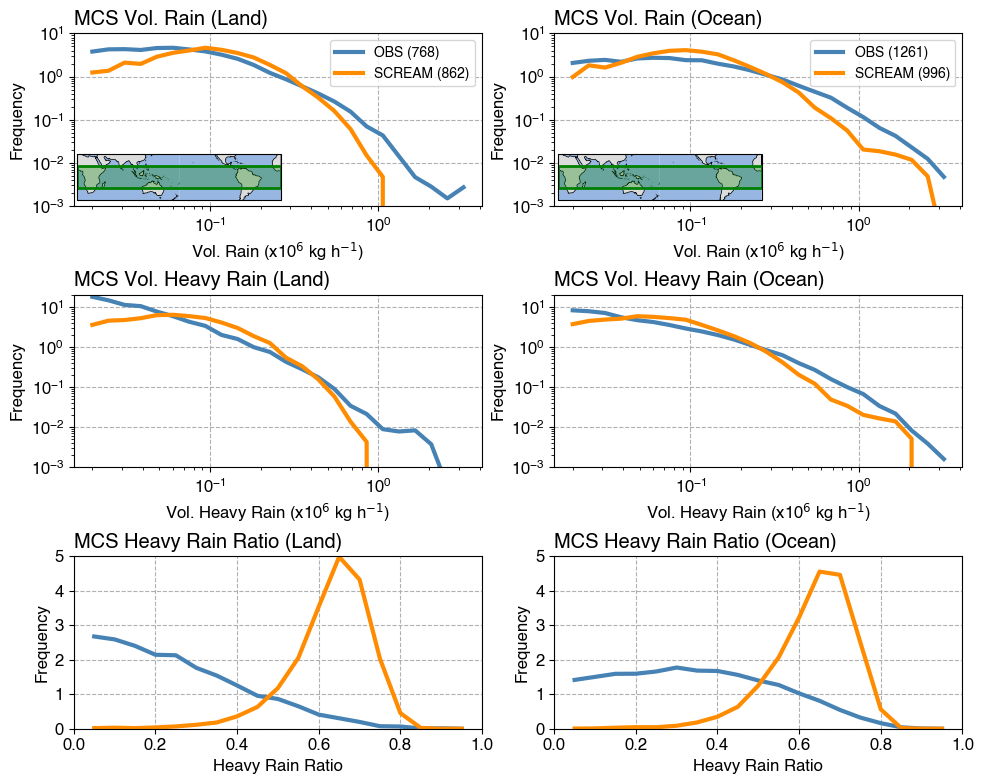

In [36]:
xbins = [volrain_bins, volrain_bins, hrr_bins]
data_obs = [[pdf_volrain_land_obs, pdf_volrain_ocean_obs],
            [pdf_volrainheavy_land_obs, pdf_volrainheavy_ocean_obs],
            [pdf_hrr_land_obs, pdf_hrr_ocean_obs]]
data_m1 = [[pdf_volrain_land_m1, pdf_volrain_ocean_m1],
            [pdf_volrainheavy_land_m1, pdf_volrainheavy_ocean_m1],
            [pdf_hrr_land_m1, pdf_hrr_ocean_m1]]
ns_obs = [[nmcs_land_obs, nmcs_ocean_obs],
          [nmcs_land_obs, nmcs_ocean_obs],
          [nmcs_land_obs, nmcs_ocean_obs]]
ns_m1 = [[nmcs_land_m1, nmcs_ocean_m1],
          [nmcs_land_m1, nmcs_ocean_m1],
          [nmcs_land_m1, nmcs_ocean_m1]]
xscales = ['log','log','linear']
yscales = ['log','log','linear']
titles = [['MCS Vol. Rain (Land)', 'MCS Vol. Rain (Ocean)'],
          ['MCS Vol. Heavy Rain (Land)', 'MCS Vol. Heavy Rain (Ocean)'],
          ['MCS Heavy Rain Ratio (Land)', 'MCS Heavy Rain Ratio (Ocean)']]
xlabels = ['Vol. Rain (x10$^{6}$ kg h$^{-1}$)', 'Vol. Heavy Rain (x10$^{6}$ kg h$^{-1}$)', 'Heavy Rain Ratio']
xticks = [np.arange(0,4.1,0.5), np.arange(0,4.1,0.5), np.arange(0,1.01,0.2)]
ylims = [[1e-3,10],[1e-3,20],[0,5.0]]

# bounds = [lon_box[0], lon_box[1], lat_box[0], lat_box[1]]
# map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-15,bounds[3]+15]
# inset_param = {'width':'30%', 'height':'35%', 'loc':'lower left', 'borderpad':0.2}
bounds = [lon_box[0], lon_box[1]-0.1, lat_box[0], lat_box[1]]
map_extent = [bounds[0],bounds[1],bounds[2]-20,bounds[3]+20]
inset_param = {'width':'50%', 'height':'30%', 'loc':'lower left', 'borderpad':0.2}

fig = plot_pdf_6panels(xbins, data_obs, data_m1, ns_obs, ns_m1, 
                       titles, xlabels, xticks, xscales, yscales, ylims, 
                       map_extent, lon_box, lat_box, inset_param, f'{figdir}pdf_volrain_volheavyrain_hrr_landocean_{region}.png',
                       legend_loc='upper right', legend_fontsize=10)

(array([  0.,   0., 516., 134.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  11.]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <BarContainer object of 14 artists>)

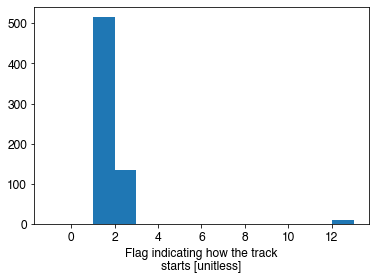

In [37]:
startstatus_ocean_obs.plot.hist(bins=np.arange(-1,14,1))

In [38]:
lifetime_ocean_obs.shape, startstatus_ocean_obs.shape

((1261,), (1261,))

In [39]:
figdir

'/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/mcs_1200x3600/figures/'

In [40]:
# def get_comp_tracks_by1cond(in_var, x_cond_var, x_cond_range, startstatus, quantiles):
#     in_var_cond = in_var.where((x_cond_var > x_cond_range[0]) & (x_cond_var <= x_cond_range[1]) & (startstatus == 10), drop=True)
#     nsamples = in_var_cond.sizes['tracks']
#     out_var_mean = in_var_cond.mean(dim='tracks')
#     out_var_qntl = in_var_cond.quantile(quantiles, dim='tracks')
#     return out_var_mean, out_var_qntl, nsamples

In [41]:
def get_comp_tracks_by1cond(in_var, x_cond_var, x_cond_range, startstatus, quantiles):
    in_var_cond = in_var.where((x_cond_var >= x_cond_range[0]) & (x_cond_var <= x_cond_range[1]) & (startstatus <= 2), drop=True)
    nsamples = in_var_cond.sizes['tracks']
    out_var_mean = in_var_cond.mean(dim='tracks')
    out_var_qntl = in_var_cond.quantile(quantiles, dim='tracks')
    return out_var_mean, out_var_qntl, nsamples

In [78]:
quantiles = [0.25, 0.5, 0.75]
# lifetime_range1 = [7, 10]
lifetime_range1 = [10, 13]
lifetime_range2 = [20, 24]
avg1_ccsarea_land_obs, qntl1_ccsarea_land_obs, ns1_land_obs = get_comp_tracks_by1cond(ccsarea_land_obs, lifetime_land_obs, lifetime_range1, startstatus_land_obs, quantiles)
avg2_ccsarea_land_obs, qntl2_ccsarea_land_obs, ns2_land_obs = get_comp_tracks_by1cond(ccsarea_land_obs, lifetime_land_obs, lifetime_range2, startstatus_land_obs, quantiles)
avg1_ccsarea_ocean_obs, qntl1_ccsarea_ocean_obs, ns1_ocean_obs = get_comp_tracks_by1cond(ccsarea_ocean_obs, lifetime_ocean_obs, lifetime_range1, startstatus_ocean_obs, quantiles)
avg2_ccsarea_ocean_obs, qntl2_ccsarea_ocean_obs, ns2_ocean_obs = get_comp_tracks_by1cond(ccsarea_ocean_obs, lifetime_ocean_obs, lifetime_range2, startstatus_ocean_obs, quantiles)

avg1_ccsarea_land_m1, qntl1_ccsarea_land_m1, ns1_land_obs = get_comp_tracks_by1cond(ccsarea_land_m1, lifetime_land_m1, lifetime_range1, startstatus_land_m1, quantiles)
avg2_ccsarea_land_m1, qntl2_ccsarea_land_m1, ns2_land_obs = get_comp_tracks_by1cond(ccsarea_land_m1, lifetime_land_m1, lifetime_range2, startstatus_land_m1, quantiles)
avg1_ccsarea_ocean_m1, qntl1_ccsarea_ocean_m1, ns1_ocean_obs = get_comp_tracks_by1cond(ccsarea_ocean_m1, lifetime_ocean_m1, lifetime_range1, startstatus_ocean_m1, quantiles)
avg2_ccsarea_ocean_m1, qntl2_ccsarea_ocean_m1, ns2_ocean_obs = get_comp_tracks_by1cond(ccsarea_ocean_m1, lifetime_ocean_m1, lifetime_range2, startstatus_ocean_m1, quantiles)

/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_

In [79]:
avg1_mintb_land_obs, qntl1_mintb_land_obs, ns1_land_obs = get_comp_tracks_by1cond(mintb_land_obs, lifetime_land_obs, lifetime_range1, startstatus_land_obs, quantiles)
avg2_mintb_land_obs, qntl2_mintb_land_obs, ns2_land_obs = get_comp_tracks_by1cond(mintb_land_obs, lifetime_land_obs, lifetime_range2, startstatus_land_obs, quantiles)
avg1_mintb_ocean_obs, qntl1_mintb_ocean_obs, ns1_ocean_obs = get_comp_tracks_by1cond(mintb_ocean_obs, lifetime_ocean_obs, lifetime_range1, startstatus_ocean_obs, quantiles)
avg2_mintb_ocean_obs, qntl2_mintb_ocean_obs, ns2_ocean_obs = get_comp_tracks_by1cond(mintb_ocean_obs, lifetime_ocean_obs, lifetime_range2, startstatus_ocean_obs, quantiles)

avg1_mintb_land_m1, qntl1_mintb_land_m1, ns1_land_m1 = get_comp_tracks_by1cond(mintb_land_m1, lifetime_land_m1, lifetime_range1, startstatus_land_m1, quantiles)
avg2_mintb_land_m1, qntl2_mintb_land_m1, ns2_land_m1 = get_comp_tracks_by1cond(mintb_land_m1, lifetime_land_m1, lifetime_range2, startstatus_land_m1, quantiles)
avg1_mintb_ocean_m1, qntl1_mintb_ocean_m1, ns1_ocean_m1 = get_comp_tracks_by1cond(mintb_ocean_m1, lifetime_ocean_m1, lifetime_range1, startstatus_ocean_m1, quantiles)
avg2_mintb_ocean_m1, qntl2_mintb_ocean_m1, ns2_ocean_m1 = get_comp_tracks_by1cond(mintb_ocean_m1, lifetime_ocean_m1, lifetime_range2, startstatus_ocean_m1, quantiles)

/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_

In [80]:
avg1_pfdiam_land_obs, qntl1_pfdiam_land_obs, ns1_land_obs = get_comp_tracks_by1cond(pfdiam_land_obs, lifetime_land_obs, lifetime_range1, startstatus_land_obs, quantiles)
avg2_pfdiam_land_obs, qntl2_pfdiam_land_obs, ns2_land_obs = get_comp_tracks_by1cond(pfdiam_land_obs, lifetime_land_obs, lifetime_range2, startstatus_land_obs, quantiles)
avg1_pfdiam_ocean_obs, qntl1_pfdiam_ocean_obs, ns1_ocean_obs = get_comp_tracks_by1cond(pfdiam_ocean_obs, lifetime_ocean_obs, lifetime_range1, startstatus_ocean_obs, quantiles)
avg2_pfdiam_ocean_obs, qntl2_pfdiam_ocean_obs, ns2_ocean_obs = get_comp_tracks_by1cond(pfdiam_ocean_obs, lifetime_ocean_obs, lifetime_range2, startstatus_ocean_obs, quantiles)

avg1_pfdiam_land_m1, qntl1_pfdiam_land_m1, ns1_land_obs = get_comp_tracks_by1cond(pfdiam_land_m1, lifetime_land_m1, lifetime_range1, startstatus_land_m1, quantiles)
avg2_pfdiam_land_m1, qntl2_pfdiam_land_m1, ns2_land_obs = get_comp_tracks_by1cond(pfdiam_land_m1, lifetime_land_m1, lifetime_range2, startstatus_land_m1, quantiles)
avg1_pfdiam_ocean_m1, qntl1_pfdiam_ocean_m1, ns1_ocean_obs = get_comp_tracks_by1cond(pfdiam_ocean_m1, lifetime_ocean_m1, lifetime_range1, startstatus_ocean_m1, quantiles)
avg2_pfdiam_ocean_m1, qntl2_pfdiam_ocean_m1, ns2_ocean_obs = get_comp_tracks_by1cond(pfdiam_ocean_m1, lifetime_ocean_m1, lifetime_range2, startstatus_ocean_m1, quantiles)

/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_

In [81]:
avg1_pfrainrate_land_obs, qntl1_pfrainrate_land_obs, ns1_land_obs = get_comp_tracks_by1cond(pfrainrate_land_obs, lifetime_land_obs, lifetime_range1, startstatus_land_obs, quantiles)
avg2_pfrainrate_land_obs, qntl2_pfrainrate_land_obs, ns2_land_obs = get_comp_tracks_by1cond(pfrainrate_land_obs, lifetime_land_obs, lifetime_range2, startstatus_land_obs, quantiles)
avg1_pfrainrate_ocean_obs, qntl1_pfrainrate_ocean_obs, ns1_ocean_obs = get_comp_tracks_by1cond(pfrainrate_ocean_obs, lifetime_ocean_obs, lifetime_range1, startstatus_ocean_obs, quantiles)
avg2_pfrainrate_ocean_obs, qntl2_pfrainrate_ocean_obs, ns2_ocean_obs = get_comp_tracks_by1cond(pfrainrate_ocean_obs, lifetime_ocean_obs, lifetime_range2, startstatus_ocean_obs, quantiles)

avg1_pfrainrate_land_m1, qntl1_pfrainrate_land_m1, ns1_land_obs = get_comp_tracks_by1cond(pfrainrate_land_m1, lifetime_land_m1, lifetime_range1, startstatus_land_m1, quantiles)
avg2_pfrainrate_land_m1, qntl2_pfrainrate_land_m1, ns2_land_obs = get_comp_tracks_by1cond(pfrainrate_land_m1, lifetime_land_m1, lifetime_range2, startstatus_land_m1, quantiles)
avg1_pfrainrate_ocean_m1, qntl1_pfrainrate_ocean_m1, ns1_ocean_obs = get_comp_tracks_by1cond(pfrainrate_ocean_m1, lifetime_ocean_m1, lifetime_range1, startstatus_ocean_m1, quantiles)
avg2_pfrainrate_ocean_m1, qntl2_pfrainrate_ocean_m1, ns2_ocean_obs = get_comp_tracks_by1cond(pfrainrate_ocean_m1, lifetime_ocean_m1, lifetime_range2, startstatus_ocean_m1, quantiles)

/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/testflex/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_

In [82]:
avg1_pfvolrain_land_obs, qntl1_pfvolrain_land_obs, ns1_land_obs = get_comp_tracks_by1cond(pfvolrain_land_obs, lifetime_land_obs, lifetime_range1, startstatus_land_obs, quantiles)
avg2_pfvolrain_land_obs, qntl2_pfvolrain_land_obs, ns2_land_obs = get_comp_tracks_by1cond(pfvolrain_land_obs, lifetime_land_obs, lifetime_range2, startstatus_land_obs, quantiles)
avg1_pfvolrain_ocean_obs, qntl1_pfvolrain_ocean_obs, ns1_ocean_obs = get_comp_tracks_by1cond(pfvolrain_ocean_obs, lifetime_ocean_obs, lifetime_range1, startstatus_ocean_obs, quantiles)
avg2_pfvolrain_ocean_obs, qntl2_pfvolrain_ocean_obs, ns2_ocean_obs = get_comp_tracks_by1cond(pfvolrain_ocean_obs, lifetime_ocean_obs, lifetime_range2, startstatus_ocean_obs, quantiles)

avg1_pfvolrain_land_m1, qntl1_pfvolrain_land_m1, ns1_land_obs = get_comp_tracks_by1cond(pfvolrain_land_m1, lifetime_land_m1, lifetime_range1, startstatus_land_m1, quantiles)
avg2_pfvolrain_land_m1, qntl2_pfvolrain_land_m1, ns2_land_obs = get_comp_tracks_by1cond(pfvolrain_land_m1, lifetime_land_m1, lifetime_range2, startstatus_land_m1, quantiles)
avg1_pfvolrain_ocean_m1, qntl1_pfvolrain_ocean_m1, ns1_ocean_obs = get_comp_tracks_by1cond(pfvolrain_ocean_m1, lifetime_ocean_m1, lifetime_range1, startstatus_ocean_m1, quantiles)
avg2_pfvolrain_ocean_m1, qntl2_pfvolrain_ocean_m1, ns2_ocean_obs = get_comp_tracks_by1cond(pfvolrain_ocean_m1, lifetime_ocean_m1, lifetime_range2, startstatus_ocean_m1, quantiles)

In [83]:
avg1_pfvolrainheavy_land_obs, qntl1_pfvolrainheavy_land_obs, ns1_land_obs = get_comp_tracks_by1cond(pfvolrainheavy_land_obs, lifetime_land_obs, lifetime_range1, startstatus_land_obs, quantiles)
avg2_pfvolrainheavy_land_obs, qntl2_pfvolrainheavy_land_obs, ns2_land_obs = get_comp_tracks_by1cond(pfvolrainheavy_land_obs, lifetime_land_obs, lifetime_range2, startstatus_land_obs, quantiles)
avg1_pfvolrainheavy_ocean_obs, qntl1_pfvolrainheavy_ocean_obs, ns1_ocean_obs = get_comp_tracks_by1cond(pfvolrainheavy_ocean_obs, lifetime_ocean_obs, lifetime_range1, startstatus_ocean_obs, quantiles)
avg2_pfvolrainheavy_ocean_obs, qntl2_pfvolrainheavy_ocean_obs, ns2_ocean_obs = get_comp_tracks_by1cond(pfvolrainheavy_ocean_obs, lifetime_ocean_obs, lifetime_range2, startstatus_ocean_obs, quantiles)

avg1_pfvolrainheavy_land_m1, qntl1_pfvolrainheavy_land_m1, ns1_land_obs = get_comp_tracks_by1cond(pfvolrainheavy_land_m1, lifetime_land_m1, lifetime_range1, startstatus_land_m1, quantiles)
avg2_pfvolrainheavy_land_m1, qntl2_pfvolrainheavy_land_m1, ns2_land_obs = get_comp_tracks_by1cond(pfvolrainheavy_land_m1, lifetime_land_m1, lifetime_range2, startstatus_land_m1, quantiles)
avg1_pfvolrainheavy_ocean_m1, qntl1_pfvolrainheavy_ocean_m1, ns1_ocean_obs = get_comp_tracks_by1cond(pfvolrainheavy_ocean_m1, lifetime_ocean_m1, lifetime_range1, startstatus_ocean_m1, quantiles)
avg2_pfvolrainheavy_ocean_m1, qntl2_pfvolrainheavy_ocean_m1, ns2_ocean_obs = get_comp_tracks_by1cond(pfvolrainheavy_ocean_m1, lifetime_ocean_m1, lifetime_range2, startstatus_ocean_m1, quantiles)

In [84]:
def plot_evolution_10panels(hours_obs, hours_m1, dataavg_obs, dataqntl_obs, dataavg_m1, dataqntl_m1, ns_obs, ns_m1,  
                            titles, xlabels, ylabels, xticks, xlims, ylims, legends, 
                            map_extent, lon_box, lat_box, inset_param, figname,
                            legend_fontsize=11, legend_loc='best'):
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=[10,12], dpi=100)

    colors = {'obs':'steelblue', 'm1':'darkorange'}

    for row in range(0,5):
        for col in range(0,2): 
            ax = axes[row][col]           
            ax.plot(hours_obs[col], dataavg_obs[row][col], colors['obs'], lw=3, label=legends['obs'])
            ax.plot(hours_m1[col], dataavg_m1[row][col], colors['m1'], lw=3, label=legends['m1'])
            ax.fill_between(hours_obs[col], dataqntl_obs[row][col][0], dataqntl_obs[row][col][1], facecolor=colors['obs'],  alpha=0.3)
            ax.fill_between(hours_m1[col], dataqntl_m1[row][col][0], dataqntl_m1[row][col][1], facecolor=colors['m1'],  alpha=0.3)

            if (row == 0): 
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row])
            ax.set_ylabel(ylabels[row])
            ax.set_xticks(xticks[col])
            ax.set_xlim(xlims[col][0], xlims[col][1])
            ax.set_ylim(ylims[row][0], ylims[row][1])
            
            # Plot inset map
            if (row == 0):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                proj = ccrs.PlateCarree(central_longitude=180)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(map_projection=proj))
                sub_ax.set_extent(map_extent, crs=box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=1)
                # Plot a box region in the inset
                box = sgeom.box(minx=lon_box[0], maxx=lon_box[1], miny=lat_box[0], maxy=lat_box[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.6, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

/tmp/ipykernel_37718/2149590244.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.6, h_pad=0.5)


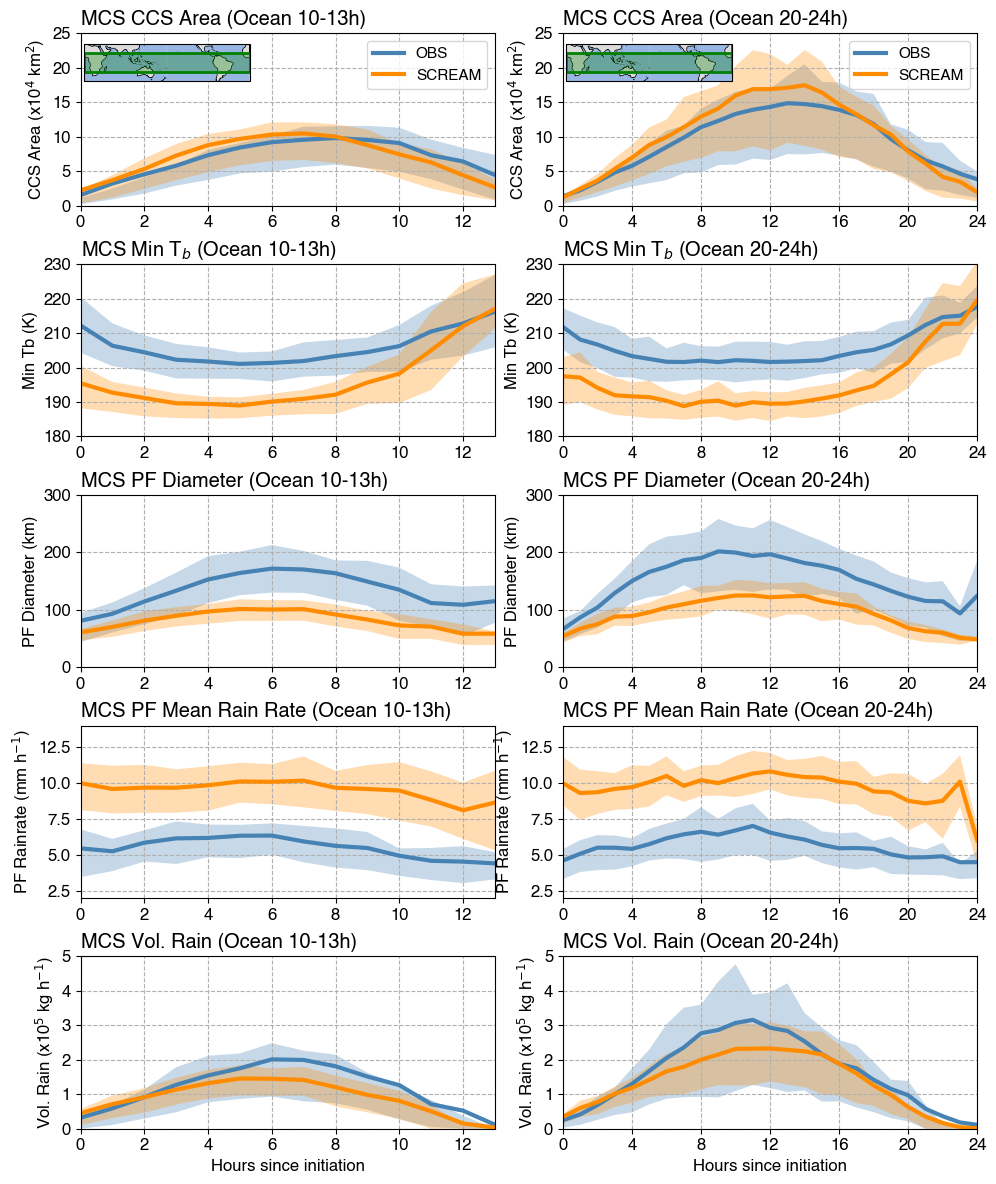

In [85]:
hours_obs = [avg1_ccsarea_ocean_obs.times, avg2_ccsarea_ocean_obs.times]
hours_m1 = [avg1_ccsarea_ocean_m1.times, avg2_ccsarea_ocean_m1.times]
dataavg_obs = [[avg1_ccsarea_ocean_obs/1e4, avg2_ccsarea_ocean_obs/1e4],
            [avg1_mintb_ocean_obs, avg2_mintb_ocean_obs],
            [avg1_pfdiam_ocean_obs, avg2_pfdiam_ocean_obs], 
            [avg1_pfrainrate_ocean_obs, avg2_pfrainrate_ocean_obs],
            [avg1_pfvolrain_ocean_obs/1e5, avg2_pfvolrain_ocean_obs/1e5]]
dataavg_m1 = [[avg1_ccsarea_ocean_m1/1e4, avg2_ccsarea_ocean_m1/1e4],
            [avg1_mintb_ocean_m1, avg2_mintb_ocean_m1],
            [avg1_pfdiam_ocean_m1, avg2_pfdiam_ocean_m1], 
            [avg1_pfrainrate_ocean_m1, avg2_pfrainrate_ocean_m1],
            [avg1_pfvolrain_ocean_m1/1e5, avg2_pfvolrain_ocean_m1/1e5]]
dataqntl_obs = [[(qntl1_ccsarea_ocean_obs.sel(quantile=0.25)/1e4,qntl1_ccsarea_ocean_obs.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_ocean_obs.sel(quantile=0.25)/1e4,qntl2_ccsarea_ocean_obs.sel(quantile=0.75)/1e4)],
                [(qntl1_mintb_ocean_obs.sel(quantile=0.25),qntl1_mintb_ocean_obs.sel(quantile=0.75)), 
                 (qntl2_mintb_ocean_obs.sel(quantile=0.25),qntl2_mintb_ocean_obs.sel(quantile=0.75))],
                [(qntl1_pfdiam_ocean_obs.sel(quantile=0.25),qntl1_pfdiam_ocean_obs.sel(quantile=0.75)), 
                 (qntl2_pfdiam_ocean_obs.sel(quantile=0.25),qntl2_pfdiam_ocean_obs.sel(quantile=0.75))],
                [(qntl1_pfrainrate_ocean_obs.sel(quantile=0.25),qntl1_pfrainrate_ocean_obs.sel(quantile=0.75)), 
                 (qntl2_pfrainrate_ocean_obs.sel(quantile=0.25),qntl2_pfrainrate_ocean_obs.sel(quantile=0.75))],
                [(qntl1_pfvolrain_ocean_obs.sel(quantile=0.25)/1e5,qntl1_pfvolrain_ocean_obs.sel(quantile=0.75)/1e5), 
                 (qntl2_pfvolrain_ocean_obs.sel(quantile=0.25)/1e5,qntl2_pfvolrain_ocean_obs.sel(quantile=0.75)/1e5)],]
dataqntl_m1 = [[(qntl1_ccsarea_ocean_m1.sel(quantile=0.25)/1e4,qntl1_ccsarea_ocean_m1.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_ocean_m1.sel(quantile=0.25)/1e4,qntl2_ccsarea_ocean_m1.sel(quantile=0.75)/1e4)],
                [(qntl1_mintb_ocean_m1.sel(quantile=0.25),qntl1_mintb_ocean_m1.sel(quantile=0.75)), 
                 (qntl2_mintb_ocean_m1.sel(quantile=0.25),qntl2_mintb_ocean_m1.sel(quantile=0.75))],
                [(qntl1_pfdiam_ocean_m1.sel(quantile=0.25),qntl1_pfdiam_ocean_m1.sel(quantile=0.75)), 
                 (qntl2_pfdiam_ocean_m1.sel(quantile=0.25),qntl2_pfdiam_ocean_m1.sel(quantile=0.75))],
                [(qntl1_pfrainrate_ocean_m1.sel(quantile=0.25),qntl1_pfrainrate_ocean_m1.sel(quantile=0.75)), 
                 (qntl2_pfrainrate_ocean_m1.sel(quantile=0.25),qntl2_pfrainrate_ocean_m1.sel(quantile=0.75))],
                [(qntl1_pfvolrain_ocean_m1.sel(quantile=0.25)/1e5,qntl1_pfvolrain_ocean_m1.sel(quantile=0.75)/1e5), 
                 (qntl2_pfvolrain_ocean_m1.sel(quantile=0.25)/1e5,qntl2_pfvolrain_ocean_m1.sel(quantile=0.75)/1e5)],]
ns_obs = [ns1_ocean_obs, ns2_ocean_obs]
ns_m1 = [ns1_ocean_m1, ns2_ocean_m1]
titles = []
titles = [[f'MCS CCS Area (Ocean {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS CCS Area (Ocean {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'MCS Min T$_b$ (Ocean {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS Min T$_b$ (Ocean {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'MCS PF Diameter (Ocean {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS PF Diameter (Ocean {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'MCS PF Mean Rain Rate (Ocean {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS PF Mean Rain Rate (Ocean {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'MCS Vol. Rain (Ocean {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS Vol. Rain (Ocean {lifetime_range2[0]}-{lifetime_range2[1]}h)']]
xlabels = ['','','','','Hours since initiation']
ylabels = ['CCS Area (x10$^{4}$ km$^2$)', 'Min Tb (K)', 'PF Diameter (km)', 'PF Rainrate (mm h$^{-1}$)', 'Vol. Rain (x10$^{5}$ kg h$^{-1}$)', ]
xticks = [np.arange(0, max(lifetime_range1)+1, 2), np.arange(0, max(lifetime_range2)+1, 4)]
xlims = [(0, max(lifetime_range1)), (0, max(lifetime_range2))]
ylims = [(0,25), (180,230), (0,300), (2,14), (0,5)]
legends = {'obs':'OBS', 'm1':'SCREAM'}
figname = f'{figdir}mcs_composite_evolution_{region}_ocean.png'

# bounds = [lon_box[0], lon_box[1], lat_box[0], lat_box[1]]
# map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-15,bounds[3]+15]
# inset_param = {'width':'30%', 'height':'35%', 'loc':'upper left', 'borderpad':0.2}
bounds = [lon_box[0], lon_box[1]-0.1, lat_box[0], lat_box[1]]
map_extent = [bounds[0],bounds[1],bounds[2]-20,bounds[3]+20]
inset_param = {'width':'40%', 'height':'30%', 'loc':'upper left', 'borderpad':0.2}

fig = plot_evolution_10panels(hours_obs, hours_m1, dataavg_obs, dataqntl_obs, dataavg_m1, dataqntl_m1, ns_obs, ns_m1,  
                              titles, xlabels, ylabels, xticks, xlims, ylims, legends, 
                              map_extent, lon_box, lat_box, inset_param, figname, legend_loc='upper right')

/tmp/ipykernel_37718/2149590244.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.6, h_pad=0.5)


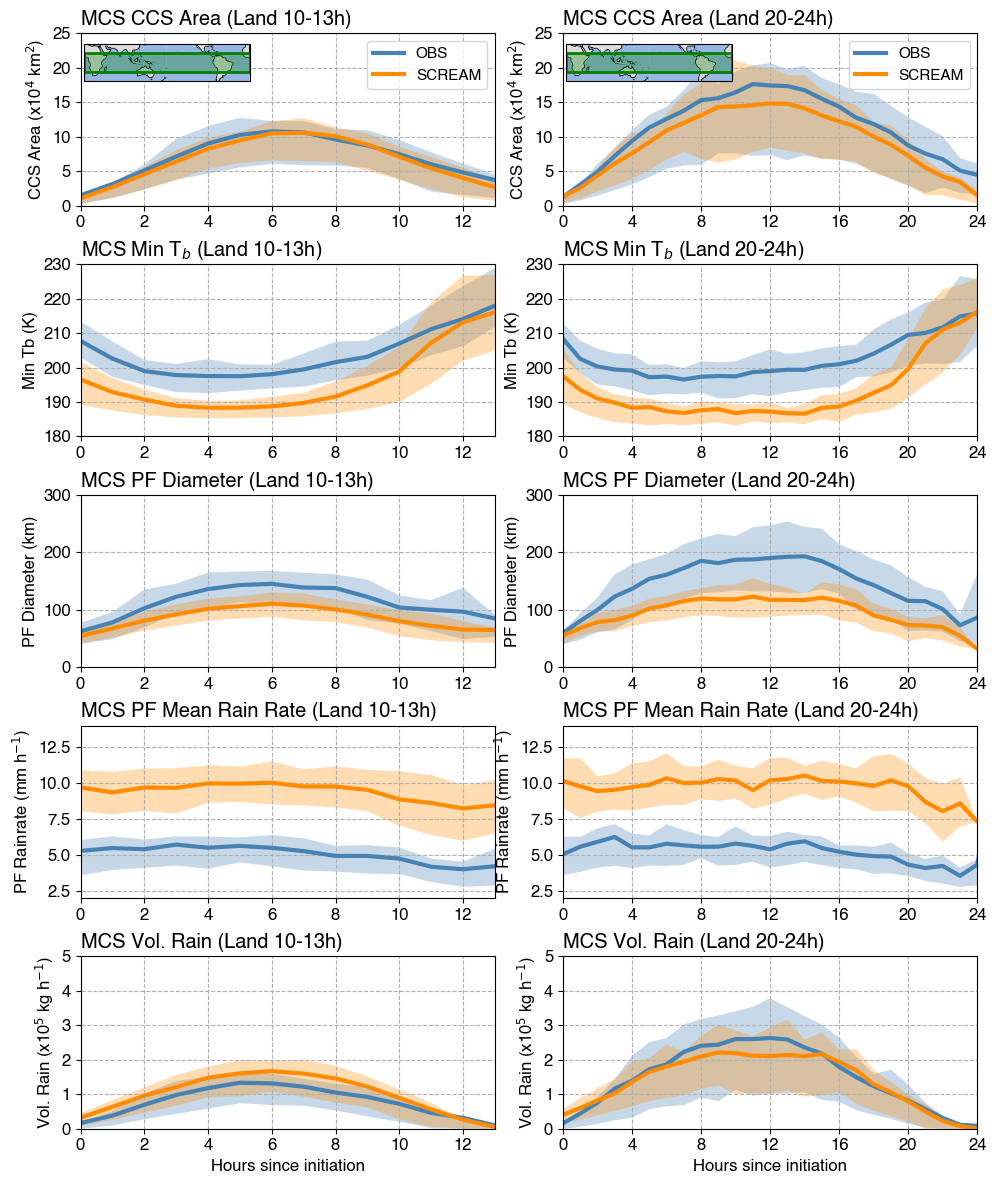

In [86]:
hours_obs = [avg1_ccsarea_land_obs.times, avg2_ccsarea_land_obs.times]
hours_m1 = [avg1_ccsarea_land_m1.times, avg2_ccsarea_land_m1.times]
dataavg_obs = [[avg1_ccsarea_land_obs/1e4, avg2_ccsarea_land_obs/1e4],
            [avg1_mintb_land_obs, avg2_mintb_land_obs],
            [avg1_pfdiam_land_obs, avg2_pfdiam_land_obs], 
            [avg1_pfrainrate_land_obs, avg2_pfrainrate_land_obs],
            [avg1_pfvolrain_land_obs/1e5, avg2_pfvolrain_land_obs/1e5]]
dataavg_m1 = [[avg1_ccsarea_land_m1/1e4, avg2_ccsarea_land_m1/1e4],
            [avg1_mintb_land_m1, avg2_mintb_land_m1],
            [avg1_pfdiam_land_m1, avg2_pfdiam_land_m1], 
            [avg1_pfrainrate_land_m1, avg2_pfrainrate_land_m1],
            [avg1_pfvolrain_land_m1/1e5, avg2_pfvolrain_land_m1/1e5]]
dataqntl_obs = [[(qntl1_ccsarea_land_obs.sel(quantile=0.25)/1e4,qntl1_ccsarea_land_obs.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_land_obs.sel(quantile=0.25)/1e4,qntl2_ccsarea_land_obs.sel(quantile=0.75)/1e4)],
                [(qntl1_mintb_land_obs.sel(quantile=0.25),qntl1_mintb_land_obs.sel(quantile=0.75)), 
                 (qntl2_mintb_land_obs.sel(quantile=0.25),qntl2_mintb_land_obs.sel(quantile=0.75))],
                [(qntl1_pfdiam_land_obs.sel(quantile=0.25),qntl1_pfdiam_land_obs.sel(quantile=0.75)), 
                 (qntl2_pfdiam_land_obs.sel(quantile=0.25),qntl2_pfdiam_land_obs.sel(quantile=0.75))],
                [(qntl1_pfrainrate_land_obs.sel(quantile=0.25),qntl1_pfrainrate_land_obs.sel(quantile=0.75)), 
                 (qntl2_pfrainrate_land_obs.sel(quantile=0.25),qntl2_pfrainrate_land_obs.sel(quantile=0.75))],
                [(qntl1_pfvolrain_land_obs.sel(quantile=0.25)/1e5,qntl1_pfvolrain_land_obs.sel(quantile=0.75)/1e5), 
                 (qntl2_pfvolrain_land_obs.sel(quantile=0.25)/1e5,qntl2_pfvolrain_land_obs.sel(quantile=0.75)/1e5)],]
dataqntl_m1 = [[(qntl1_ccsarea_land_m1.sel(quantile=0.25)/1e4,qntl1_ccsarea_land_m1.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_land_m1.sel(quantile=0.25)/1e4,qntl2_ccsarea_land_m1.sel(quantile=0.75)/1e4)],
                [(qntl1_mintb_land_m1.sel(quantile=0.25),qntl1_mintb_land_m1.sel(quantile=0.75)), 
                 (qntl2_mintb_land_m1.sel(quantile=0.25),qntl2_mintb_land_m1.sel(quantile=0.75))],
                [(qntl1_pfdiam_land_m1.sel(quantile=0.25),qntl1_pfdiam_land_m1.sel(quantile=0.75)), 
                 (qntl2_pfdiam_land_m1.sel(quantile=0.25),qntl2_pfdiam_land_m1.sel(quantile=0.75))],
                [(qntl1_pfrainrate_land_m1.sel(quantile=0.25),qntl1_pfrainrate_land_m1.sel(quantile=0.75)), 
                 (qntl2_pfrainrate_land_m1.sel(quantile=0.25),qntl2_pfrainrate_land_m1.sel(quantile=0.75))],
                [(qntl1_pfvolrain_land_m1.sel(quantile=0.25)/1e5,qntl1_pfvolrain_land_m1.sel(quantile=0.75)/1e5), 
                 (qntl2_pfvolrain_land_m1.sel(quantile=0.25)/1e5,qntl2_pfvolrain_land_m1.sel(quantile=0.75)/1e5)],]
ns_obs = [ns1_land_obs, ns2_land_obs]
ns_m1 = [ns1_land_m1, ns2_land_m1]
titles = []
titles = [[f'MCS CCS Area (Land {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS CCS Area (Land {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'MCS Min T$_b$ (Land {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS Min T$_b$ (Land {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'MCS PF Diameter (Land {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS PF Diameter (Land {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'MCS PF Mean Rain Rate (Land {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS PF Mean Rain Rate (Land {lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'MCS Vol. Rain (Land {lifetime_range1[0]}-{lifetime_range1[1]}h)', f'MCS Vol. Rain (Land {lifetime_range2[0]}-{lifetime_range2[1]}h)']]
xlabels = ['','','','','Hours since initiation']
ylabels = ['CCS Area (x10$^{4}$ km$^2$)', 'Min Tb (K)', 'PF Diameter (km)', 'PF Rainrate (mm h$^{-1}$)', 'Vol. Rain (x10$^{5}$ kg h$^{-1}$)', ]
xticks = [np.arange(0, max(lifetime_range1)+1, 2), np.arange(0, max(lifetime_range2)+1, 4)]
xlims = [(0, max(lifetime_range1)), (0, max(lifetime_range2))]
ylims = [(0,25), (180,230), (0,300), (2,14), (0,5)]
legends = {'obs':'OBS', 'm1':'SCREAM'}
figname = f'{figdir}mcs_composite_evolution_{region}_land.png'

fig = plot_evolution_10panels(hours_obs, hours_m1, dataavg_obs, dataqntl_obs, dataavg_m1, dataqntl_m1, ns_obs, ns_m1,  
                              titles, xlabels, ylabels, xticks, xlims, ylims, legends, 
                              map_extent, lon_box, lat_box, inset_param, figname, legend_loc='upper right')

In [87]:
figdir

'/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/mcs_1200x3600/figures/'

In [88]:
avg1_ccsarea_ocean_obs.times, avg1_ccsarea_ocean_m1.times

(<xarray.DataArray 'times' (times: 200)>
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 

(0.0, 200000.0)

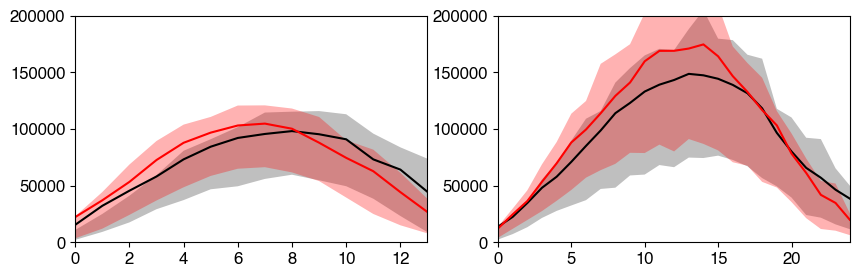

In [89]:
hours_obs = avg1_ccsarea_ocean_obs.times
hours_m1 = avg1_ccsarea_ocean_m1.times
fig, axs = plt.subplots(1,2, figsize=[10,3], dpi=100)
ax = axs[0]
ax.plot(hours_obs, avg1_ccsarea_ocean_obs, 'k', label='OBS (Ocean)')
ax.plot(hours_m1, avg1_ccsarea_ocean_m1, 'r', label='E3SM (Ocean)')
ax.fill_between(hours_obs, qntl1_ccsarea_ocean_obs.sel(quantile=0.25), qntl1_ccsarea_ocean_obs.sel(quantile=0.75), facecolor='gray',  alpha=0.5)
ax.fill_between(hours_m1, qntl1_ccsarea_ocean_m1.sel(quantile=0.25), qntl1_ccsarea_ocean_m1.sel(quantile=0.75), facecolor='r',  alpha=0.3)
ax.set_xlim(0, max(lifetime_range1))
ax.set_ylim(0,200000)

ax = axs[1]
ax.plot(hours_obs, avg2_ccsarea_ocean_obs, 'k', label='OBS (Ocean)')
ax.plot(hours_m1, avg2_ccsarea_ocean_m1, 'r', label='E3SM (Ocean)')
ax.fill_between(hours_obs, qntl2_ccsarea_ocean_obs.sel(quantile=0.25), qntl2_ccsarea_ocean_obs.sel(quantile=0.75), facecolor='gray',  alpha=0.5)
ax.fill_between(hours_m1, qntl2_ccsarea_ocean_m1.sel(quantile=0.25), qntl2_ccsarea_ocean_m1.sel(quantile=0.75), facecolor='r',  alpha=0.3)
ax.set_xlim(0, max(lifetime_range2))
ax.set_ylim(0,200000)

(180.0, 230.0)

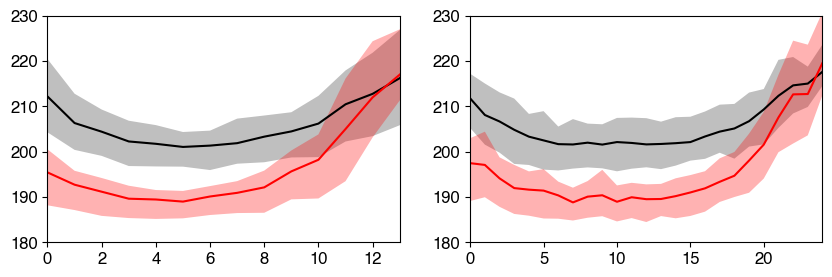

In [90]:
fig, axs = plt.subplots(1,2, figsize=[10,3], dpi=100)
ax = axs[0]
ax.plot(hours_obs, avg1_mintb_ocean_obs, 'k', label='OBS (Ocean)')
ax.plot(hours_m1, avg1_mintb_ocean_m1, 'r', label='E3SM (Ocean)')
ax.fill_between(hours_obs, qntl1_mintb_ocean_obs.sel(quantile=0.25), qntl1_mintb_ocean_obs.sel(quantile=0.75), facecolor='gray',  alpha=0.5)
ax.fill_between(hours_m1, qntl1_mintb_ocean_m1.sel(quantile=0.25), qntl1_mintb_ocean_m1.sel(quantile=0.75), facecolor='r',  alpha=0.3)
ax.set_xlim(0, max(lifetime_range1))
ax.set_ylim(180,230)

ax = axs[1]
ax.plot(hours_obs, avg2_mintb_ocean_obs, 'k', label='OBS (Ocean)')
ax.plot(hours_m1, avg2_mintb_ocean_m1, 'r', label='E3SM (Ocean)')
ax.fill_between(hours_obs, qntl2_mintb_ocean_obs.sel(quantile=0.25), qntl2_mintb_ocean_obs.sel(quantile=0.75), facecolor='gray',  alpha=0.5)
ax.fill_between(hours_m1, qntl2_mintb_ocean_m1.sel(quantile=0.25), qntl2_mintb_ocean_m1.sel(quantile=0.75), facecolor='r',  alpha=0.3)
ax.set_xlim(0, max(lifetime_range2))
ax.set_ylim(180,230)